# Beginner Stock Price Prediction (inear Regression)

This is a simple, beginner-friendly notebook that uses classic data mining steps:

1) Collect data with yfinance (daily bars)
2) Create lag features: Close(t-1), Close(t-2), ..., Close(t-N)
3) Split by time (latest X% for test)
4) Train a Linear Regression model
5) Evaluate with MAE, RMSE, MAPE and visualize Actual vs Predicted
6) Make a naive next-day prediction

Tip: You can run each cell top-to-bottom. If the notebook already had prior content, you can ignore cells below this section.

In [5]:
# 1) Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf

In [6]:
# 2) Parameters (you can change these)
ticker = "GOOG"      # e.g., 'AAPL', 'MSFT'
period = "1y"        # '6mo', '1y', '2y', '5y'
lags = 5             # number of lag days to use as features
test_size_pct = 20   # percent of most recent data to use for testing

C:\Users\Prakshil\AppData\Local\Temp\ipykernel_9144\2351636950.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval="1d")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            GOOG        GOOG        GOOG        GOOG      GOOG
Date                                                                
2025-10-23  253.729996  255.860001  252.768005  253.699997  13241300
2025-10-24  260.510010  262.510010  256.100006  257.299988  18406000
2025-10-27  269.929993  270.799988  264.940002  265.359985  22987700
2025-10-28  268.429993  271.380005  267.170013  270.200012  20101200
2025-10-29  275.170013  275.970001  268.429993  268.609985  25788900


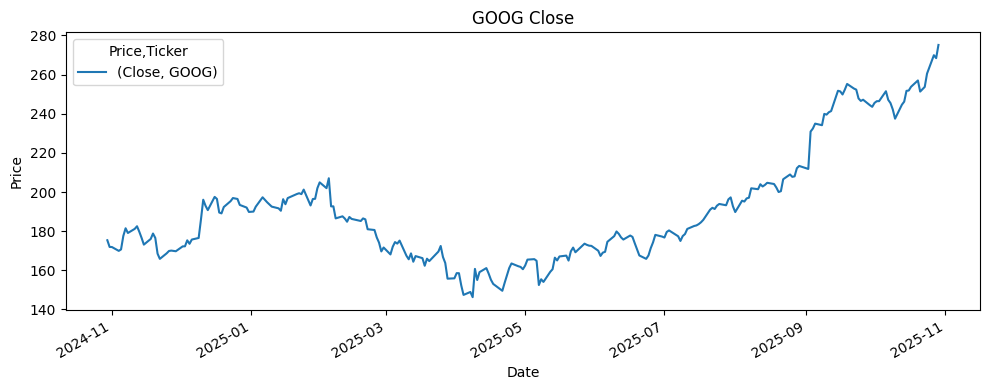

In [7]:
# 3) Download daily data

df = yf.download(ticker, period=period, interval="1d")
if df is None or df.empty:
    raise SystemExit("No data downloaded. Check the ticker or period.")

# Prefer 'Adj Close', else 'Close'
price_col = "Adj Close" if "Adj Close" in df.columns else ("Close" if "Close" in df.columns else None)
if price_col is None:
    raise SystemExit("No 'Adj Close' or 'Close' column found.")

print(df.tail())
df[[price_col]].plot(title=f"{ticker} {price_col}", figsize=(10,4))
plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()

In [9]:
# 4) Make lag features (supervised dataset)

def make_supervised(series: pd.Series, lags: int) -> pd.DataFrame:
    data = pd.DataFrame({"target": series})
    for i in range(1, lags + 1):
        data[f"lag_{i}"] = series.shift(i)
    return data.dropna()

series = df[price_col].squeeze().astype(float)
supervised = make_supervised(series, lags)
print("Rows after lagging:", len(supervised))
if len(supervised) < 20:
    raise SystemExit("Not enough rows after lagging. Reduce 'lags' or increase 'period'.")

Rows after lagging: 245


In [10]:
# 5) Time-based split: last X% as test

test_size = max(1, int(len(supervised) * (test_size_pct / 100.0)))
train = supervised.iloc[:-test_size]
test = supervised.iloc[-test_size:]

X_train = train.drop(columns=["target"]).values
y_train = train["target"].values
X_test = test.drop(columns=["target"]).values
y_test = test["target"].values

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 196, Test size: 49


In [11]:
# 6) Fit Linear Regression and evaluate

linreg = LinearRegression()
linreg.fit(X_train, y_train)

pred = linreg.predict(X_test)
rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
mae = float(mean_absolute_error(y_test, pred))
with np.errstate(divide='ignore', invalid='ignore'):
    mape_vals = np.abs((pred - y_test) / np.where(y_test == 0, np.nan, y_test)) * 100.0
    mape = float(np.nanmean(mape_vals))

print(f"RMSE: {rmse:,.4f}")
print(f"MAE:  {mae:,.4f}")
print(f"MAPE: {mape:,.2f}%")

RMSE: 5.1348
MAE:  3.6431
MAPE: 1.50%


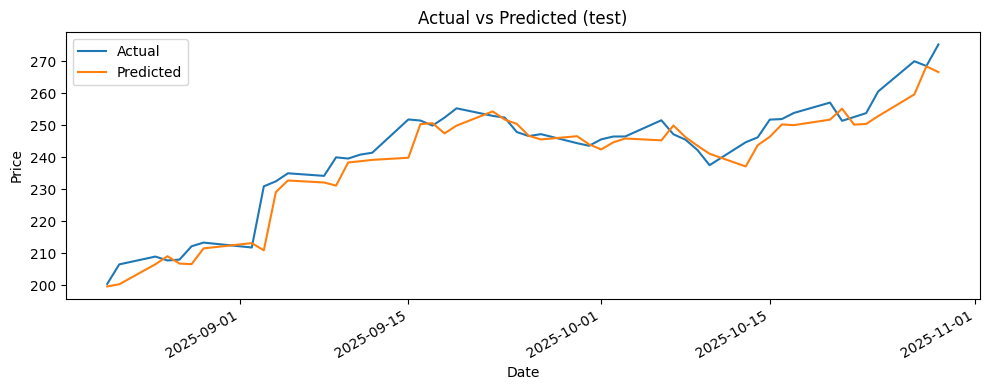

In [12]:
# 7) Visualize Actual vs Predicted (test)

ax = pd.DataFrame({
    "Actual": y_test,
    "Predicted": pred,
}, index=test.index).plot(figsize=(10,4), title="Actual vs Predicted (test)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()

In [13]:
# 8) Naive next-day prediction using latest lags

latest_lags = [series.iloc[-i] for i in range(1, lags + 1)]
latest_X = np.array(latest_lags).reshape(1, -1)
next_day_pred = float(linreg.predict(latest_X)[0])
print(f"Predicted next close for {ticker}: {next_day_pred:,.2f}")

Predicted next close for GOOG: 271.47
